In [1]:
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
eps = np.finfo("float").eps

plt.style.use(["science", "ieee"])
out_path = osp.join("../outputs/figures")
metric_res_dicts_path = osp.join(out_path, "metric_res_dicts.npy")


In [3]:
metric_res_dicts= np.load(metric_res_dicts_path,allow_pickle=True).item()

In [4]:
datasets = ['Pinterest','MovieLens', 'Clothing', 'Toys']

# Plot performance

mAP


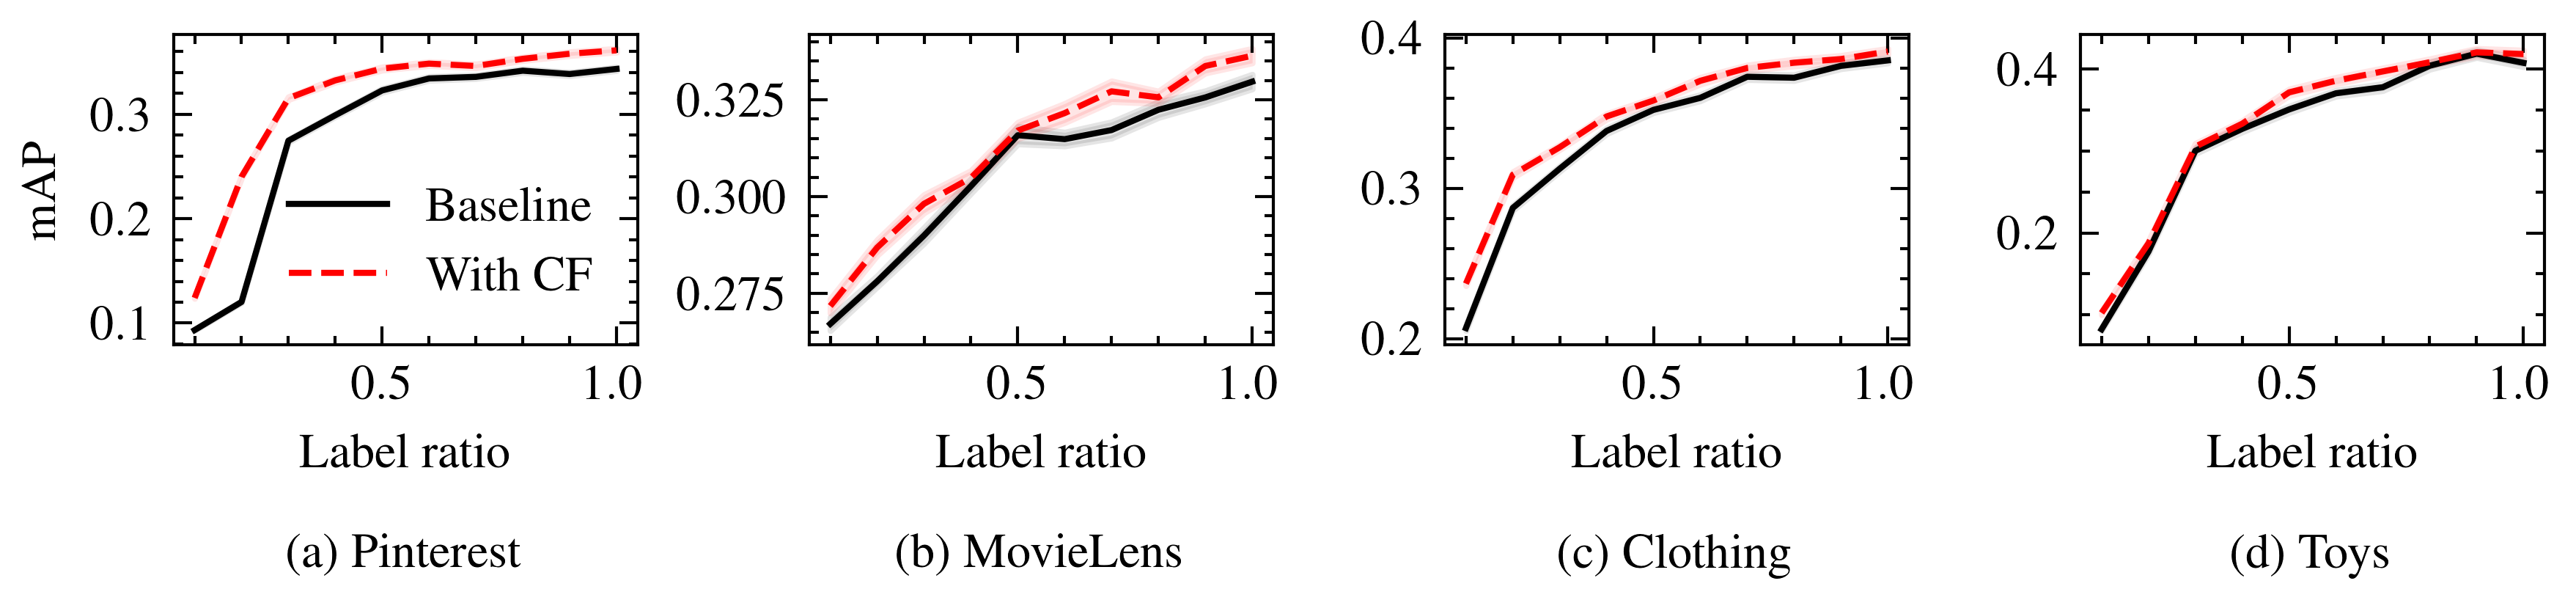

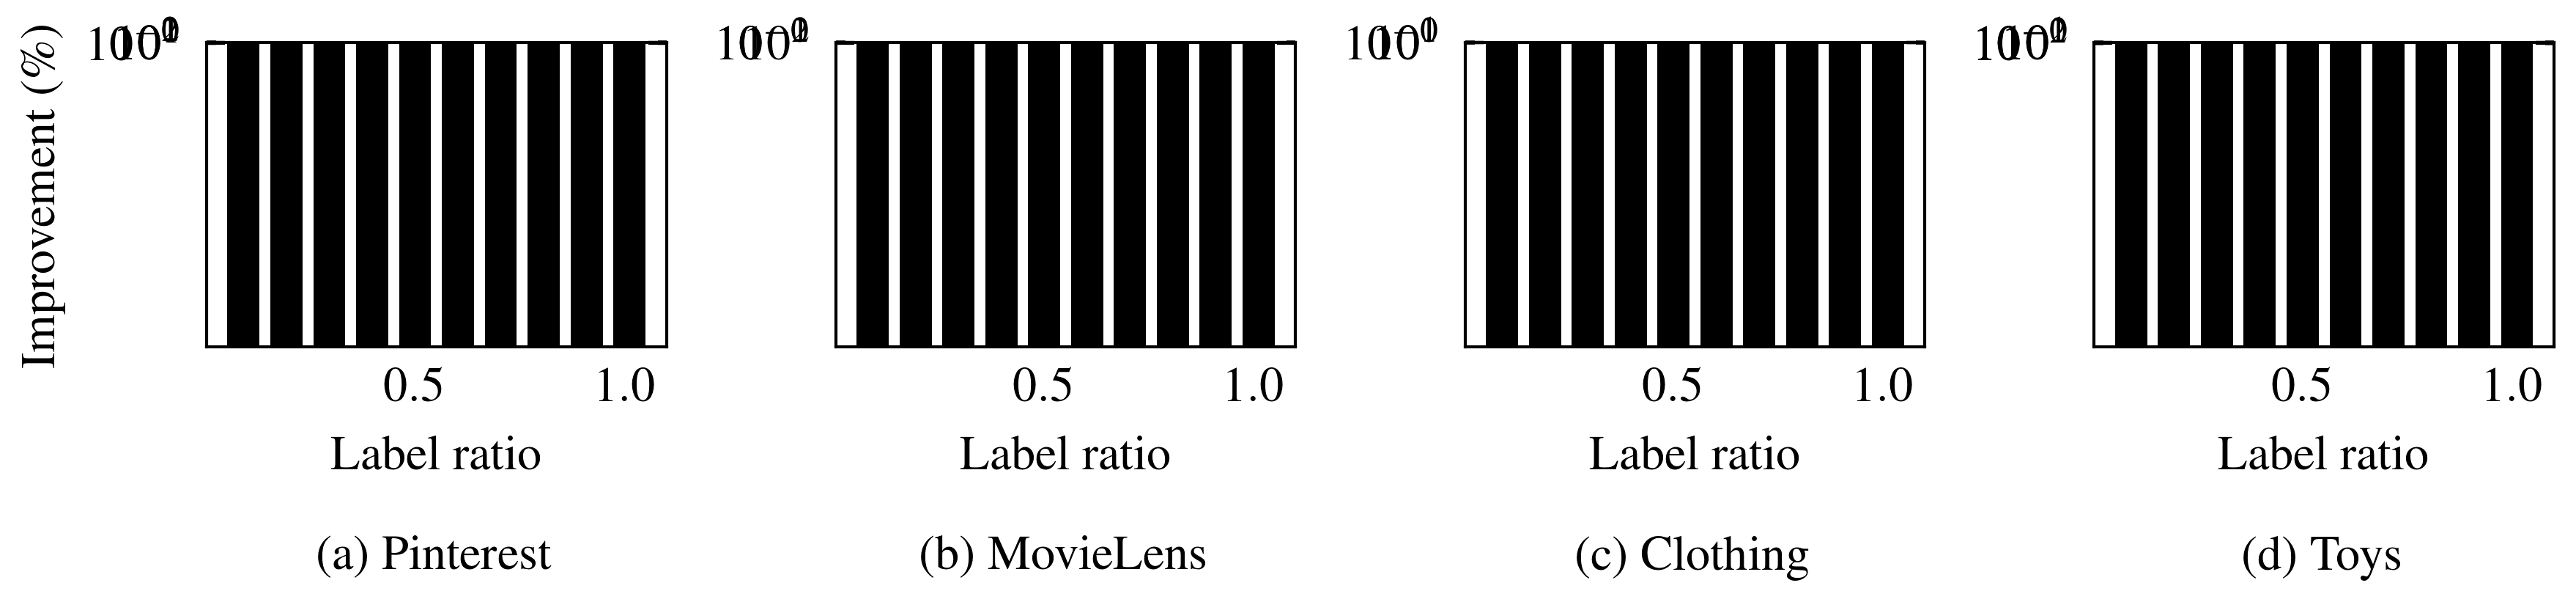

Top 1 accuracy


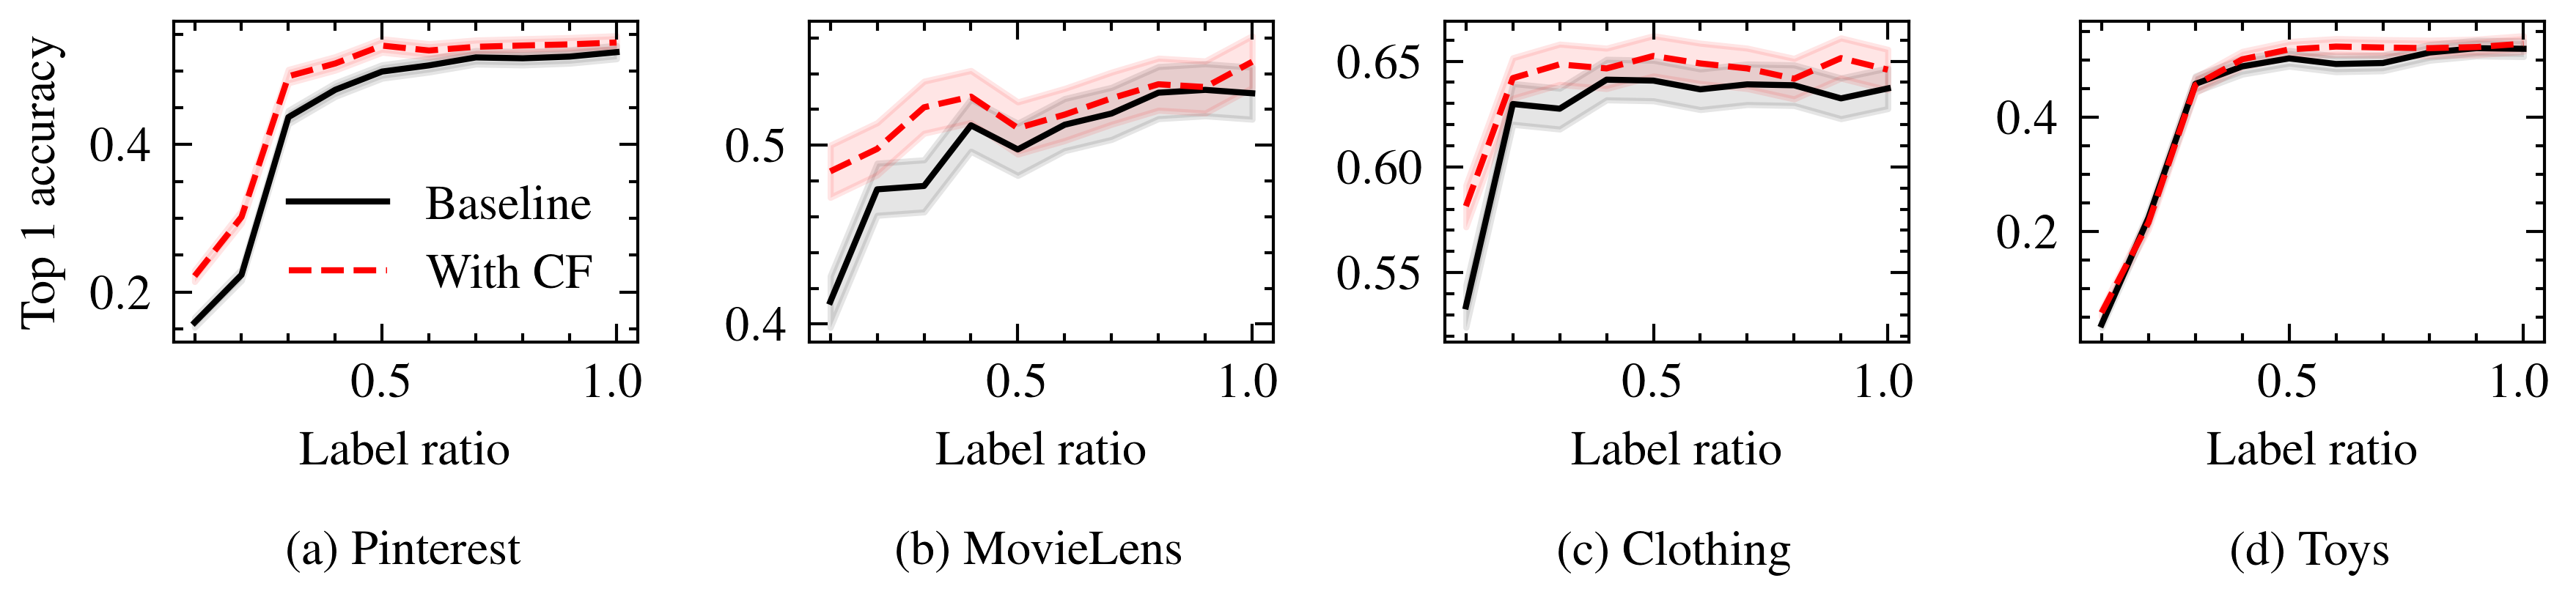

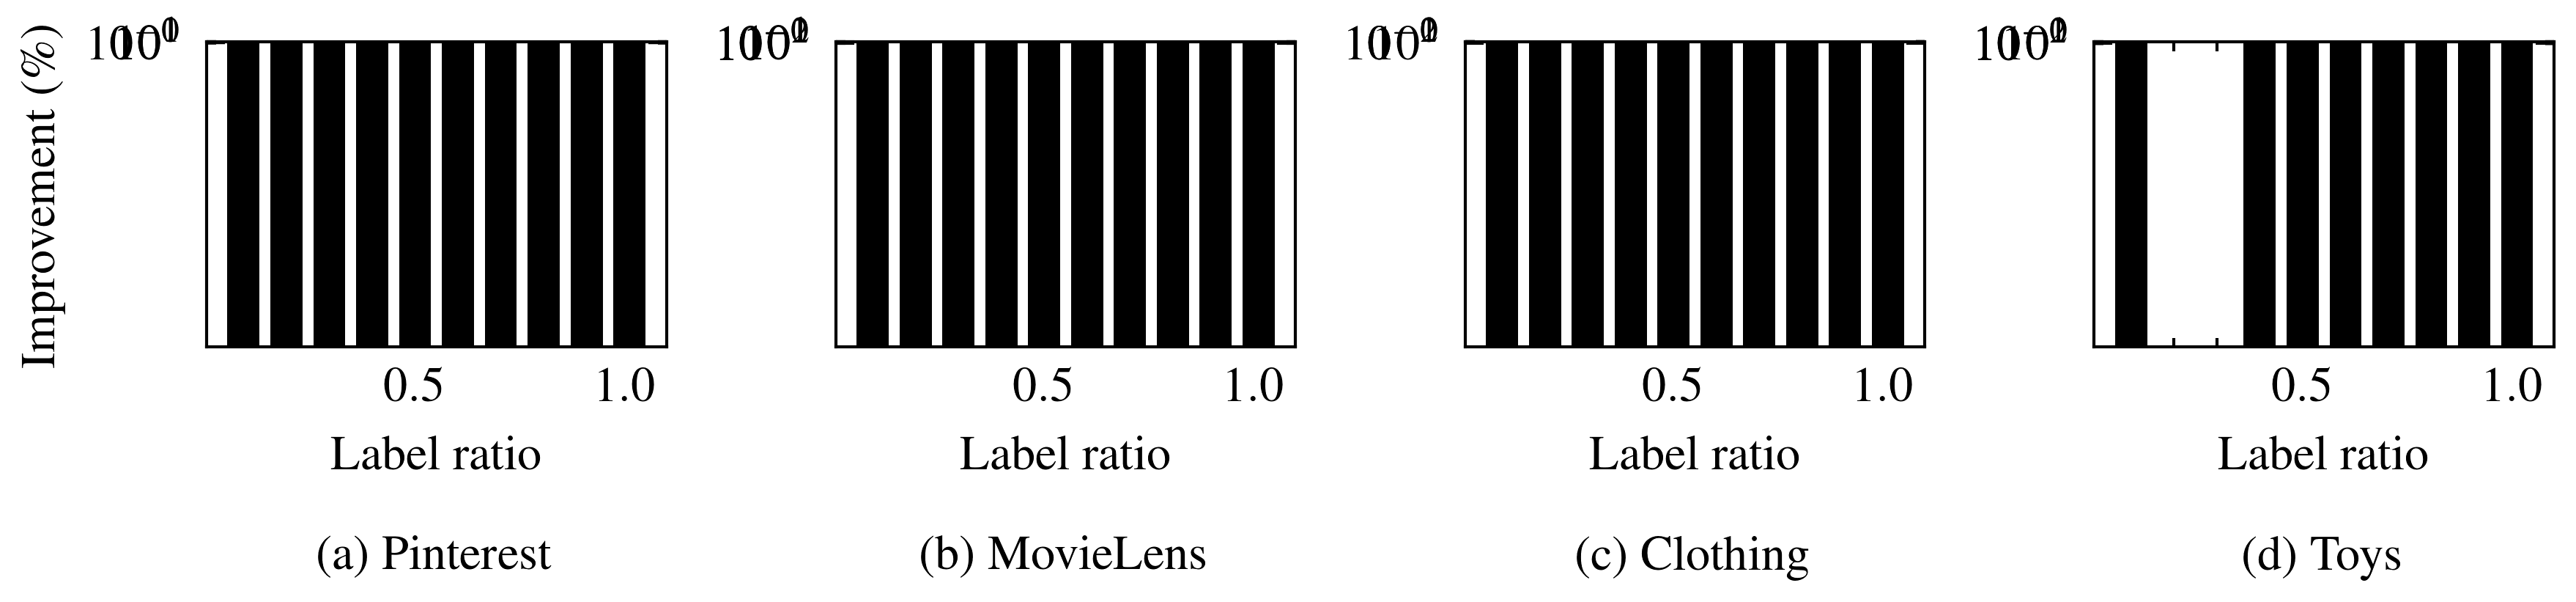

Recall@1


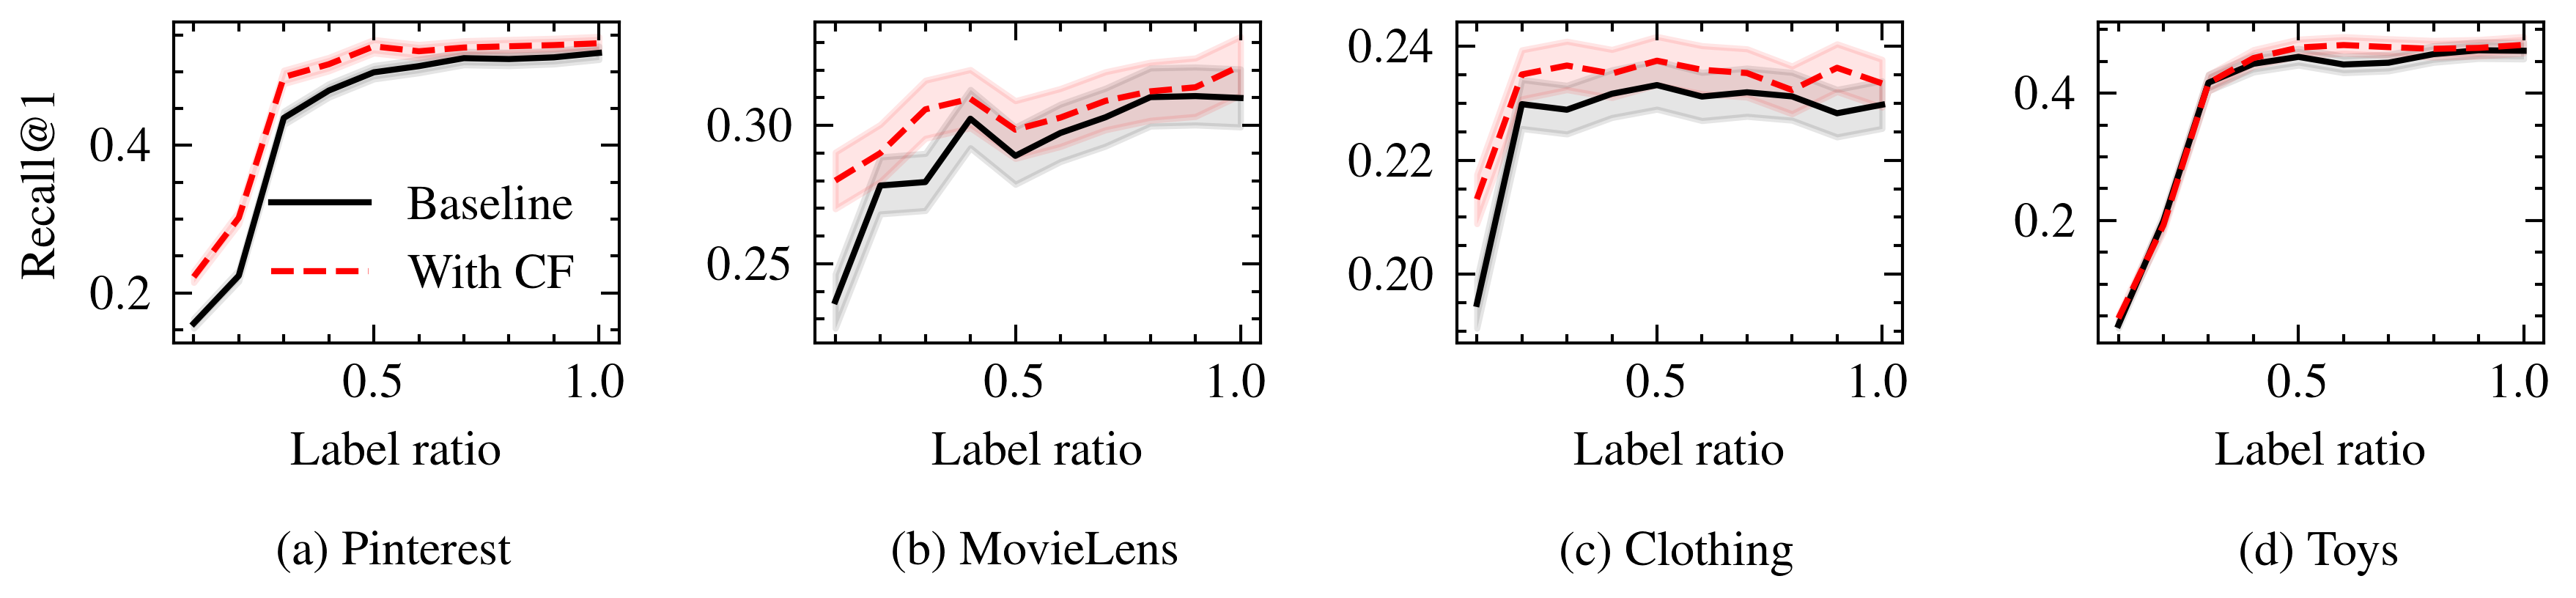

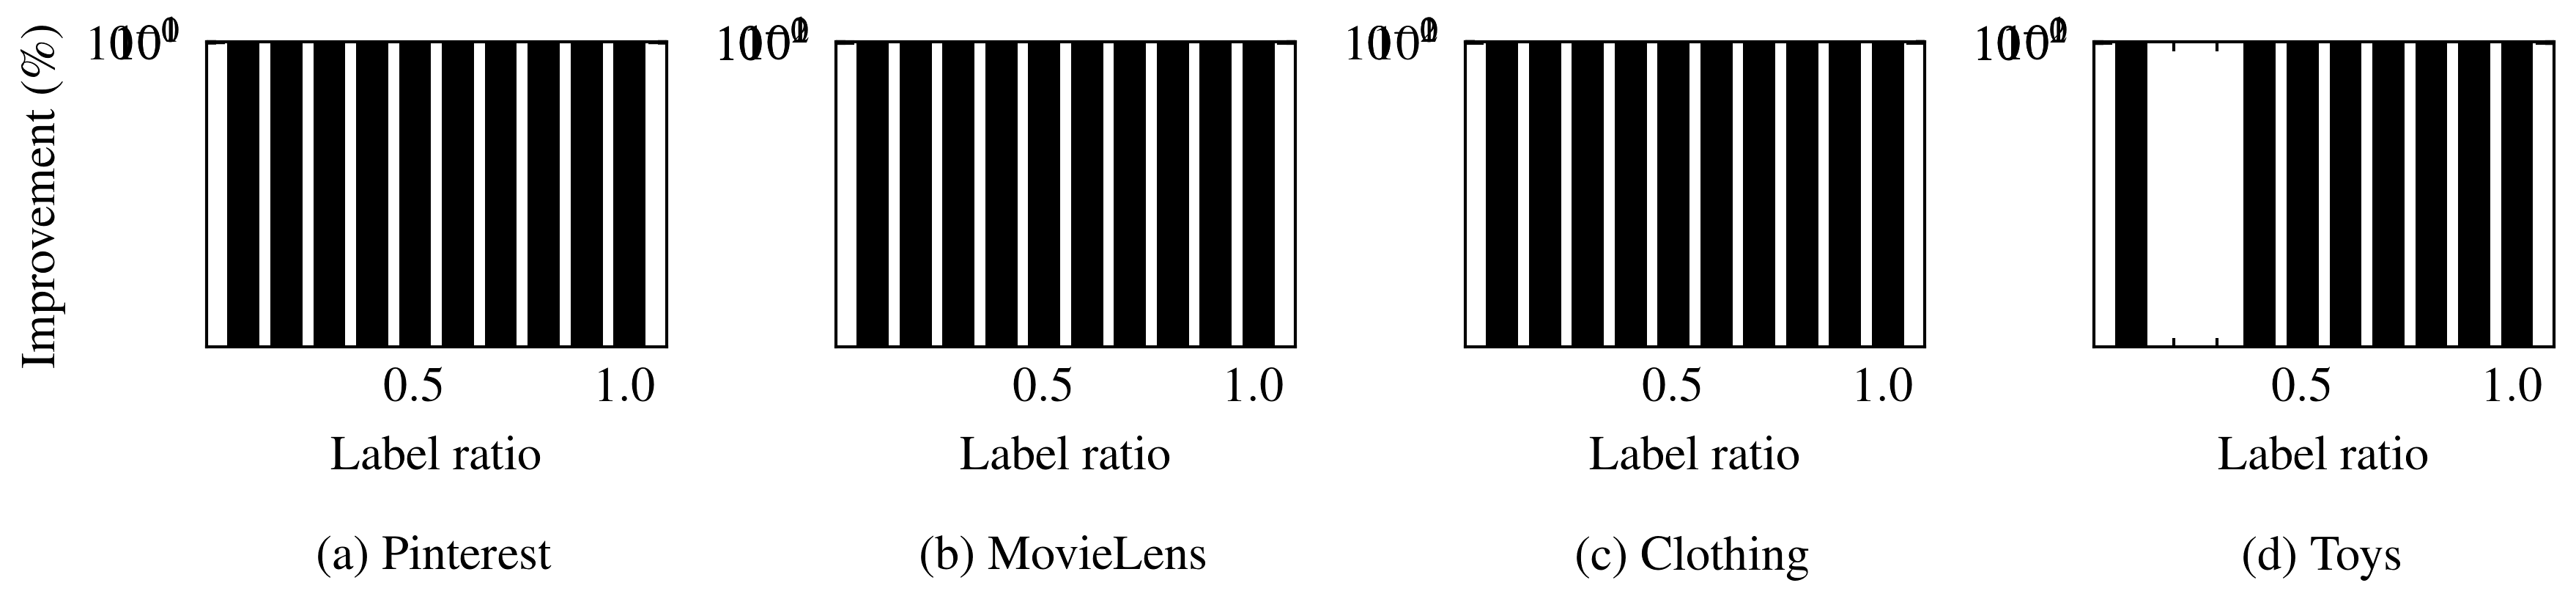

Recall@3


KeyboardInterrupt: 

In [9]:
# metric_name_to_print= ['mAP', 'Top1 accuracy']
for k, (metric_name, single_metric_res_dict) in enumerate(metric_res_dicts.items()):
    print(metric_name)
    fig, axs = plt.subplots(1, 4, figsize=(6, 1.5))

    for row, dataset_name in enumerate(datasets): 
        # print(dataset_name)
        # print(df[['no_cf','with_cf', 'improvement']].T)
        df = single_metric_res_dict[dataset_name]
        ax = axs[row]

        ax.plot(df['label_ratio'], df["no_cf"], label="Baseline")
        ax.plot(df['label_ratio'], df["with_cf"], label="With CF")

        for i, key in enumerate(["no_cf", "with_cf"]):
            ax.fill_between(
                df['label_ratio'],
                df[key] - df[key + "_ci"],
                df[key] + df[key + "_ci"],
                color=f"C{i}",
                alpha=0.1,
            )

        ax.set_xlabel("Label ratio \n\n ({}) {}".format(chr(row + 97), dataset_name))
    axs[0].legend()
    # axs[0].set_ylabel(metric_name_to_print[k])
    axs[0].set_ylabel(metric_name.replace('_', ' '))

    plt.tight_layout()
    plt.savefig(osp.join(out_path,metric_name + '.pdf'))
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(6, 1.5))
    for row, dataset_name in enumerate(datasets): 
        df = single_metric_res_dict[dataset_name]

        ax = axs[row]
        ax.bar(df['label_ratio'], df["improvement"]*100, width=0.075)
        ax.set_xlabel("Label ratio \n\n ({}) {}".format(chr(row + 97), dataset_name))
        ax.set_ylim(bottom=0.0)
        ax.set_yscale('log')
    axs[0].set_ylabel("Improvement (\%)")
    plt.tight_layout()
    plt.savefig(osp.join(out_path,metric_name + 'improvment.pdf'))
    plt.show()



In [3]:
path0 = '/home/ubuntu/cactus/outputs/pinterest/train_model_multirun_20220108_093359/9_cf_weight=0.0_labeled_ratio=1.0'
path1 = '/home/ubuntu/cactus/outputs/pinterest/train_model_multirun_20220108_090451/9_cf_weight=5.0_labeled_ratio=1.0'

labels = np.load(osp.join(path0, "labels.npy"))

preds_a = np.load(osp.join(path0, "preds.npy"))
preds_b = np.load(osp.join(path1, "preds.npy"))

In [ ]:
num_samples = labels.sum(axis=0)
num_samples

array([1084.,  612.,  664.,  641.,  263.,  510.,  174.,  199.,  307.,
        115.,  289.,  392.,  123.,   36.,  305.,   27.,  339.,  318.,
         66.,   34.,  511.,  142.,  179.,   37.,  108.,  130.,   86.,
        100.,   24.,  174.,   34.,   96.], dtype=float32)

In [12]:
from sklearn.metrics import average_precision_score
ap_a = average_precision_score(labels,preds_a,average=None)
ap_b = average_precision_score(labels,preds_b,average=None)
idxs = np.argsort(num_samples)
ap_a = ap_a[idxs]
ap_b = ap_b[idxs]


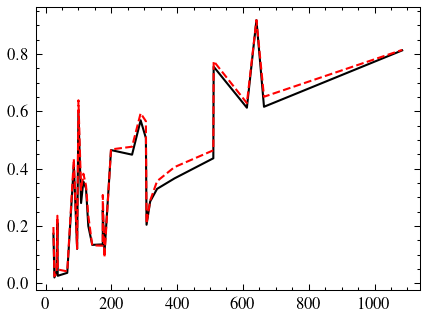

In [13]:
fig, ax= plt.subplots(1,1,dpi=150)
plt.plot(num_samples[idxs],ap_a, label='Baseline')
plt.plot(num_samples[idxs],ap_b, label='With CF')
plt.show()



In [25]:
import pandas as pd
df = pd.read_pickle('/home/ubuntu/cactus/outputs/pinterest/df_test.pkl')
cf_df=pd.read_pickle('/home/ubuntu/cactus/outputs/pinterest/cf_df.pkl')
cf_df["asin"] =cf_df["asin"].astype(df["asin"].dtype)

df = pd.merge(df, cf_df, on=["asin"], how="inner")


In [38]:
ap_a, ap_b,intercations = [],[],[]
for label_i, a_i,b_i,inter_i in zip(labels,preds_a,preds_b,df['num_intercations']):
    
    if np.sum(label_i) == 0:
        continue
    ap_a.append(average_precision_score(label_i,a_i))
    ap_b.append(average_precision_score(label_i,b_i))
    intercations.append(inter_i)

ap_a = np.array(ap_a)
ap_b = np.array(ap_b)
intercations = np.array(intercations)
   
# idxs = np.argsort(intercations)
# ap_a =ap_a[idxs]
# ap_b =ap_b[idxs]
# intercations =intercations[idxs]


In [ ]:
ap_a, ap_b,intercations = [],[],[]
for label_i, a_i,b_i,inter_i in zip(labels,preds_a,preds_b,df['num_intercations']):
    
    if np.sum(label_i) == 0:
        continue
    ap_a.append(average_precision_score(label_i,a_i))
    ap_b.append(average_precision_score(label_i,b_i))
    intercations.append(inter_i)

ap_a = np.array(ap_a)
ap_b = np.array(ap_b)
intercations = np.array(intercations)

In [48]:
intercations = df['num_intercations'].to_numpy()[:,np.newaxis]

ap_a = average_precision_score(labels,preds_a,average=None)
ap_b = average_precision_score(labels,preds_b,average=None)
ratio = ap_b/ap_a

intercations_per_category = (labels * intercations).sum(axis=0)
idxs = np.argsort(intercations_per_category)[::-1]
intercations_per_category = intercations_per_category[idxs]
ratio = ratio[idxs]

In [52]:
intercations_per_category,ratio

(array([11064.,  6805.,  6600.,  6303.,  5681.,  4644.,  3959.,  3863.,
         3529.,  3366.,  3212.,  3197.,  2899.,  1964.,  1887.,  1829.,
         1638.,  1548.,  1400.,  1372.,  1312.,  1289.,  1285.,  1004.,
          798.,   654.,   375.,   374.,   348.,   347.,   298.,   220.]),
 array([1.00204478, 1.05679593, 1.02570589, 0.99995894, 1.02633204,
        1.06374237, 1.10778158, 1.01137977, 1.0815785 , 1.1157725 ,
        1.04302584, 1.02130781, 1.06198718, 1.20278841, 1.00476943,
        0.87353524, 0.96545528, 0.98760242, 1.07668738, 1.03065948,
        1.18240178, 1.16303703, 1.07603639, 1.00684614, 1.04987898,
        1.14239991, 0.73094671, 1.85795755, 0.8246123 , 1.11661565,
        1.22523734, 1.13660817]))

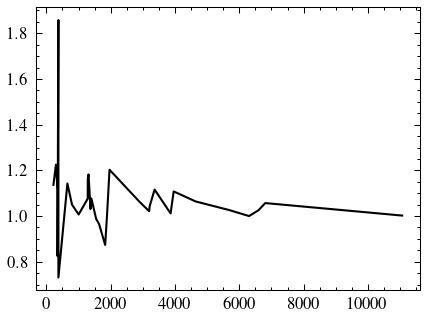

In [50]:
fig, ax= plt.subplots(1,1,dpi=150)
plt.plot(intercations_per_category,ratio)
plt.show()

In [35]:
idxs = np.argsort(ap_b)[::-1]
ap_a =ap_a[idxs]
ap_b =ap_b[idxs]
intercations =intercations[idxs]


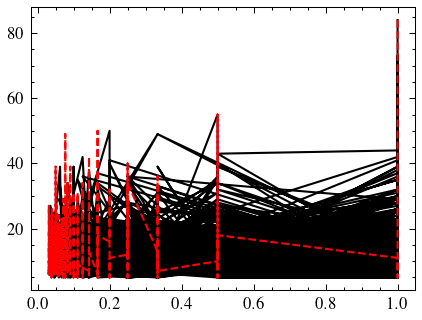

In [37]:
fig, ax= plt.subplots(1,1,dpi=150)
plt.plot(ap_a, intercations, label='Baseline')
plt.plot(ap_b,intercations, label='With CF')
plt.show()